# Análisis de Accidentes de Motocicleta en EE.UU. usando Python y el Dataset FARS

## Introducción

En esta práctica se desarrolla un análisis exploratorio de datos aplicando herramientas vistas en el curso, como **NumPy**, **Pandas** y **Matplotlib**, con el fin de profundizar en el tratamiento, manipulación y visualización de conjuntos de datos reales y complejos.

El conjunto de datos utilizado proviene de **FARS (Fatality Analysis Reporting System)**, un sistema gestionado por la *Administración Nacional de Seguridad del Tráfico en las Carreteras de Estados Unidos* (NHTSA), que recopila información detallada sobre accidentes de tráfico fatales ocurridos en todo el país.

Este análisis se enfoca exclusivamente en los accidentes de motocicleta, con el propósito de **extraer información relevante para la seguridad vial de los motociclistas**. A través del procesamiento y visualización de estos datos, se espera detectar patrones frecuentes, zonas del cuerpo más afectadas, influencia del uso de casco, factores de riesgo y otros elementos críticos para la prevención de accidentes fatales.

El trabajo se estructura en etapas que incluyen la carga y limpieza de los datos, su análisis descriptivo y la representación gráfica de los resultados más relevantes. Con esto, se busca no solo cumplir los objetivos técnicos de la asignatura, sino también generar una reflexión crítica sobre la importancia del análisis de datos en la toma de decisiones sociales.

URL oficial del dataset: https://www.nhtsa.gov/research-data/fatality-analysis-reporting-system-fars

He subido los 3 archivos que usé para este trabajo en mi Drive:
https://drive.google.com/drive/folders/1vzlmkjx4c9GyPmh16XbdahaLPBf1DZIt?usp=sharing

---


# Análisis, Carga y Limpieza de los Datasets

He realizado un análisis de las estructuras (Archivos, columnas) del dataset FARS y para este trabajo considero que solo necesitaré 3 archivos de los que vienen en el dataset, además de esto solo he elegido algunas columnas relevantes, en el código siguiente delimito cuales columnas de cada archivo y genero un dataset con solo la información necesaria

In [40]:
import pandas as pd
import numpy as np

# Ruta a la carpeta de datos
ruta = "Data/"

# 1. Cargar solo las columnas necesarias
cols_accident = ['ST_CASE', 'STATE', 'STATENAME', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'WEATHER', 'WEATHERNAME']
cols_vehicle  = ['ST_CASE', 'VEH_NO', 'BODY_TYP', 'MAN_COLLNAME']
cols_person   = ['ST_CASE', 'VEH_NO', 'PER_NO', 'SEX', 'AGE', 'HELM_USE', 'HELM_USENAME', 'INJ_SEV', 'INJ_SEVNAME', 'DRUGS', 'DRUGSNAME']

df_accident = pd.read_csv(ruta + 'ACCIDENT.csv', usecols=cols_accident, encoding='latin1', low_memory=False)
df_vehicle  = pd.read_csv(ruta + 'VEHICLE.csv',  usecols=cols_vehicle,  encoding='latin1', low_memory=False)
df_person   = pd.read_csv(ruta + 'PERSON.csv',   usecols=cols_person,   encoding='latin1', low_memory=False)

# 2. Filtrar solo vehículos tipo motocicleta (códigos 80–89)
df_vehicle = df_vehicle[df_vehicle['BODY_TYP'].between(80, 89)]

# 3. Realizar los joins según ST_CASE y VEH_NO
df_merge = (
    df_accident
    .merge(df_vehicle, on='ST_CASE', how='inner')
    .merge(df_person, on=['ST_CASE', 'VEH_NO'], how='inner')
)

# 4. Crear columnas derivadas (como en SQL)
# ------------------------------
# Casco
def clasificar_casco(valor):
    if valor in [1, 2, 3]:
        return 'Con casco'
    elif valor == 5:
        return 'Casco mal usado'
    elif valor in [4, 17]:
        return 'Sin casco'
    elif valor == 19:
        return 'Casco tipo desconocido'
    elif valor in [98, 99]:
        return 'No reportado / Desconocido'
    else:
        return 'Otro'

df_merge['USO_CASCO_DETALLE'] = df_merge['HELM_USE'].apply(clasificar_casco)

# Gravedad
df_merge['GRAVEDAD_LESION'] = df_merge['INJ_SEV'].replace({
    4: 'Fatal',
    3: 'Lesión grave',
    2: 'Lesión leve',
    0: 'Sin lesión'
}).fillna('Desconocido')

# Drogas
def clasificar_drogas(valor):
    if valor == 0:
        return 'Sin drogas'
    elif 1 <= valor <= 5:
        return 'Drogas detectadas'
    elif valor == 6:
        return 'Sospecha de drogas, sin prueba'
    elif valor == 8:
        return 'No se hizo prueba'
    elif valor == 9:
        return 'Desconocido'
    else:
        return 'Otro'

df_merge['USO_DROGAS_DETALLE'] = df_merge['DRUGS'].apply(clasificar_drogas)

# Clima - Español
def clasificar_clima(valor):
    if valor == 'Clear':
        return 'Despejado'
    elif valor == 'Cloudy':
        return 'Nublado'
    elif valor == 'Rain':
        return 'Lluvia'
    elif valor == 'Snow':
        return 'Nieve'
    elif valor == 'Sleet/Hail':
        return 'Aguanieve/Granizo'
    elif valor == 'Fog/Smog/Smoke':
        return 'Niebla/Humo'
    elif valor == 'Severe Crosswinds':
        return 'Vientos fuertes'
    elif valor == 'Blowing Sand, Soil, Dirt':
        return 'Polvo o arena en el aire'
    elif valor == 'Other':
        return 'Otro'
    elif valor == 'Not Reported':
        return 'No reportado'
    elif valor == 'Unknown':
        return 'Desconocido'
    else:
        return 'No especificado'

# Aplicar al DataFrame
df_merge['CLIMA_ES'] = df_merge['WEATHERNAME'].apply(clasificar_clima)


# 5. Resultado final
print(f"Dataset final: {df_merge.shape}")
display(df_merge.head())


Dataset final: (6332, 25)


,STATE,STATENAME,ST_CASE,DAY,MONTH,YEAR,HOUR,WEATHER,WEATHERNAME,VEH_NO,...,INJ_SEV,INJ_SEVNAME,DRUGS,DRUGSNAME,HELM_USE,HELM_USENAME,USO_CASCO_DETALLE,GRAVEDAD_LESION,USO_DROGAS_DETALLE,CLIMA_ES
0,1,Alabama,10087,20,2,2020,0,10,Cloudy,1,...,4,Fatal Injury (K),9,Reported as Unknown,5,DOT-Compliant Motorcycle Helmet,Casco mal usado,Fatal,Desconocido,Nublado
1,1,Alabama,10114,16,2,2020,12,10,Cloudy,1,...,4,Fatal Injury (K),9,Reported as Unknown,5,DOT-Compliant Motorcycle Helmet,Casco mal usado,Fatal,Desconocido,Nublado
2,1,Alabama,10153,15,3,2020,17,1,Clear,1,...,4,Fatal Injury (K),0,No (drugs not involved),5,DOT-Compliant Motorcycle Helmet,Casco mal usado,Fatal,Sin drogas,Despejado
3,1,Alabama,10201,16,4,2020,19,1,Clear,2,...,4,Fatal Injury (K),8,Not Reported,19,"Helmet, Unknown if DOT-Compliant",Casco tipo desconocido,Fatal,No se hizo prueba,Despejado
4,1,Alabama,10215,25,4,2020,21,1,Clear,1,...,4,Fatal Injury (K),0,No (drugs not involved),5,DOT-Compliant Motorcycle Helmet,Casco mal usado,Fatal,Sin drogas,Despejado


# Gráficas y Análisis exploratorio y descriptivo

### Distribución de la gravedad de la lesión

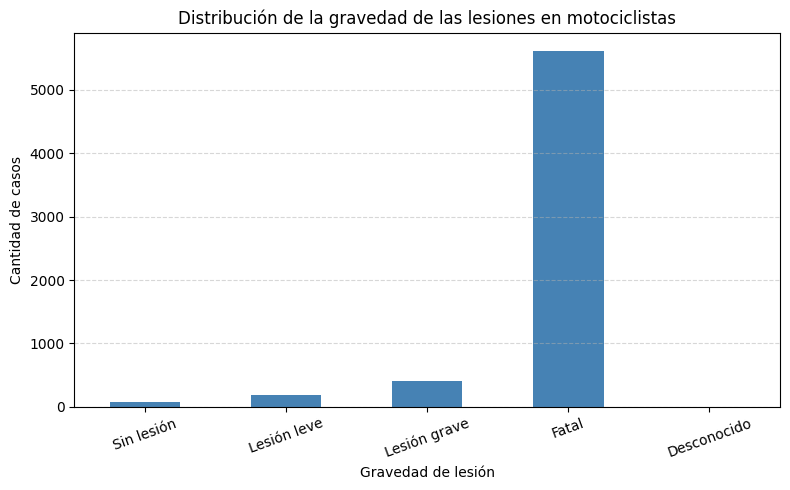

In [36]:
import matplotlib.pyplot as plt

# Conteo de casos por tipo de lesión
gravedad_counts = df_merge['GRAVEDAD_LESION'].value_counts().reindex(
    ['Sin lesión', 'Lesión leve', 'Lesión grave', 'Fatal', 'Desconocido'], fill_value=0)

# Gráfico de barras
plt.figure(figsize=(8, 5))
gravedad_counts.plot(kind='bar', color='steelblue')
plt.title('Distribución de la gravedad de las lesiones en motociclistas')
plt.xlabel('Gravedad de lesión')
plt.ylabel('Cantidad de casos')
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Relación entre uso de casco y mortalidad

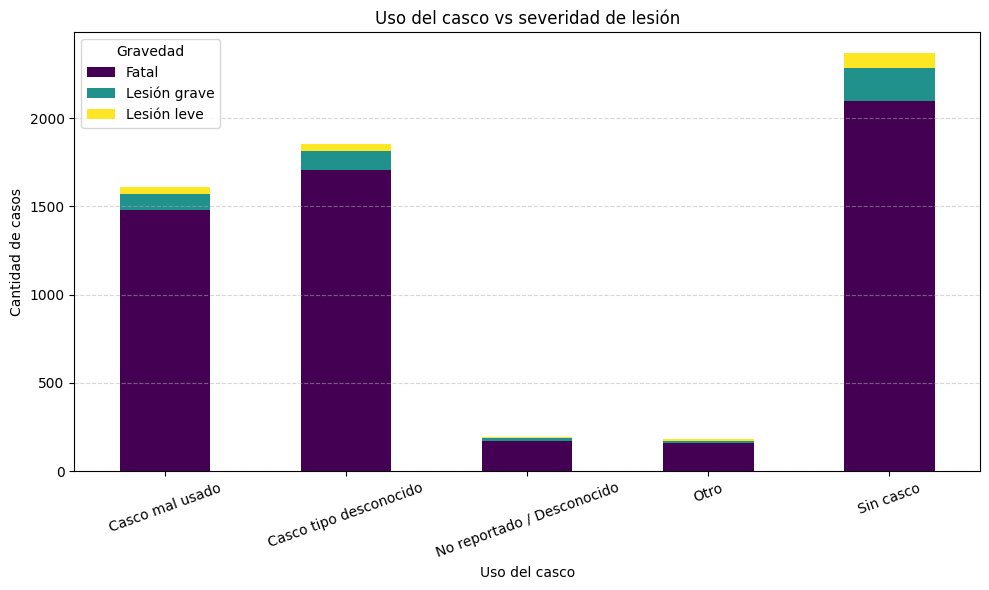

In [37]:
# Tabla cruzada
casco_vs_gravedad = pd.crosstab(df_merge['USO_CASCO_DETALLE'], df_merge['GRAVEDAD_LESION'])

# Gráfico de barras apiladas
casco_vs_gravedad[['Fatal', 'Lesión grave', 'Lesión leve']].plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Uso del casco vs severidad de lesión')
plt.xlabel('Uso del casco')
plt.ylabel('Cantidad de casos')
plt.legend(title='Gravedad')
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Distribución de edades

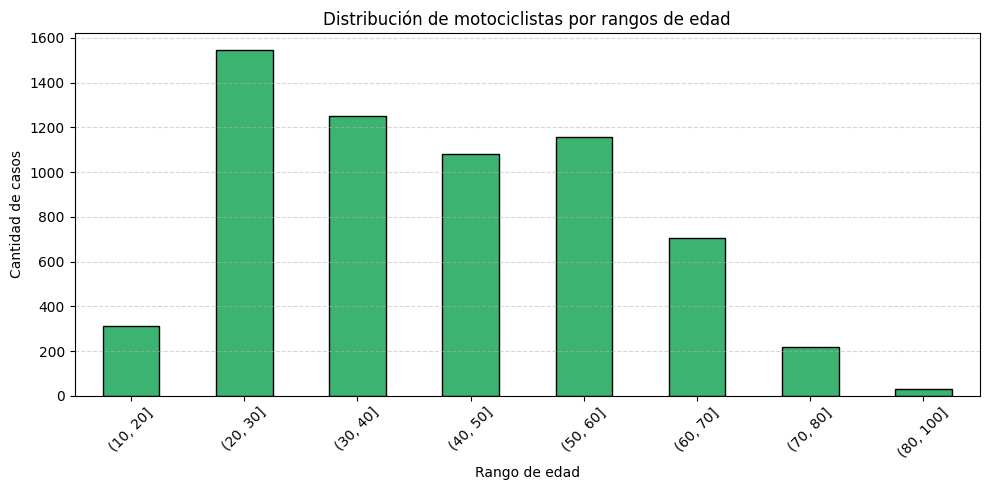

In [26]:
# Filtrar edades válidas
df_edades = df_merge[df_merge['AGE'].between(10, 100)].copy()

# Crear rangos de edad personalizados
edad_bins = pd.cut(df_edades['AGE'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 100])
edad_counts = edad_bins.value_counts().sort_index()

# Gráfico de barras por rangos
plt.figure(figsize=(10, 5))
edad_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Distribución de motociclistas por rangos de edad')
plt.xlabel('Rango de edad')
plt.ylabel('Cantidad de casos')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




### Accidentes por hora del día

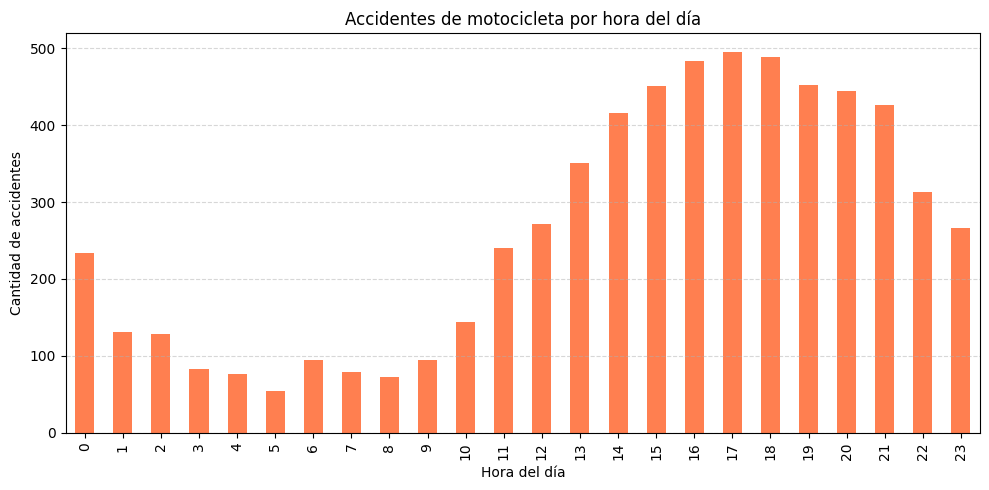

In [22]:
df_horas = df_merge[df_merge['HOUR'] < 25]  # filtrar registros válidos

plt.figure(figsize=(10, 5))
df_horas['HOUR'].value_counts().sort_index().plot(kind='bar', color='coral')
plt.title('Accidentes de motocicleta por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de accidentes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Accidentes según el clima

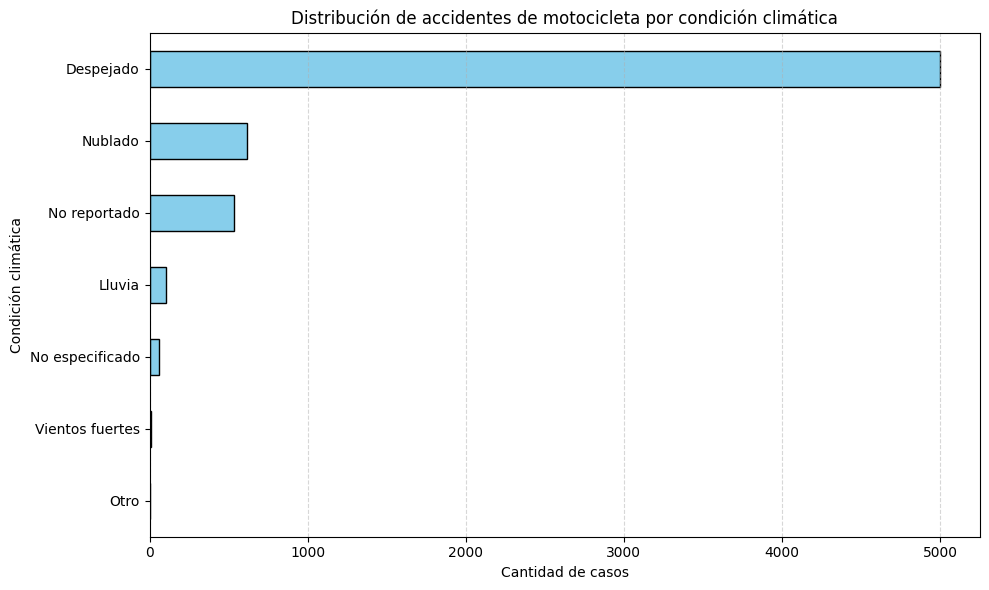

In [41]:
# Contar casos por tipo de clima
clima_counts = df_merge['CLIMA_ES'].value_counts().sort_values(ascending=True)

# Gráfico horizontal de barras
plt.figure(figsize=(10, 6))
clima_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Distribución de accidentes de motocicleta por condición climática')
plt.xlabel('Cantidad de casos')
plt.ylabel('Condición climática')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Uso de drogas vs gravedad de la lesión

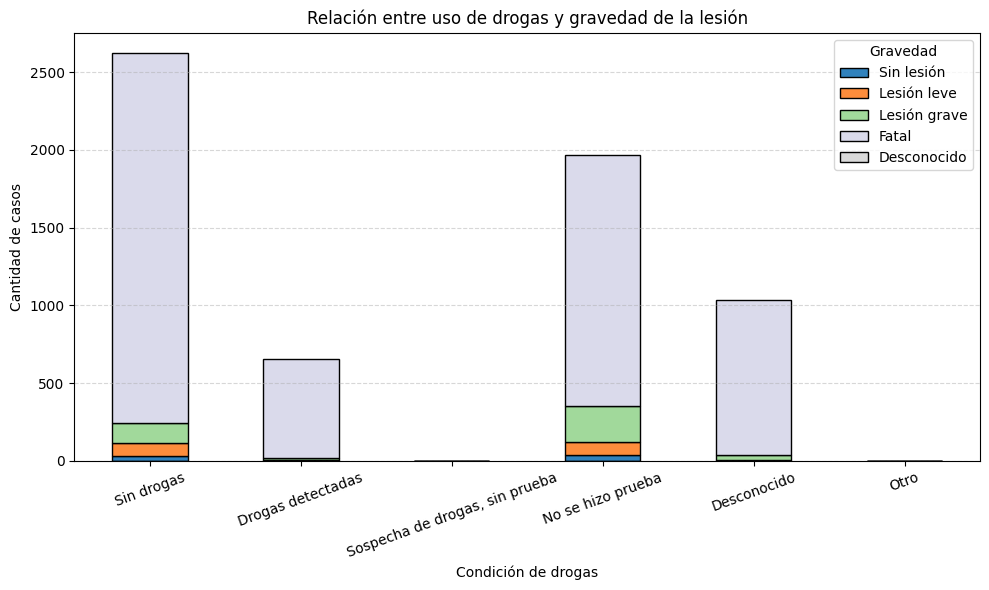

In [38]:
# Tabla cruzada de drogas vs severidad
drogas_vs_lesion = pd.crosstab(df_merge['USO_DROGAS_DETALLE'], df_merge['GRAVEDAD_LESION'])

# Ordenar categorías si deseas (opcional)
orden_drogas = ['Sin drogas', 'Drogas detectadas', 'Sospecha de drogas, sin prueba',
                'No se hizo prueba', 'Desconocido', 'Otro']
orden_lesiones = ['Sin lesión', 'Lesión leve', 'Lesión grave', 'Fatal', 'Desconocido']

# Asegurar el orden de las filas y columnas
drogas_vs_lesion = drogas_vs_lesion.reindex(index=orden_drogas, columns=orden_lesiones, fill_value=0)

# Gráfico de barras apiladas
drogas_vs_lesion.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20c', edgecolor='black')
plt.title('Relación entre uso de drogas y gravedad de la lesión')
plt.xlabel('Condición de drogas')
plt.ylabel('Cantidad de casos')
plt.legend(title='Gravedad')
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Aplicación NumPy

### Estadísticas básicas con NumPy (Edades)

In [29]:
import numpy as np

# Crear array NumPy de edades válidas
edades = df_merge['AGE']
edades_validas = edades[(edades >= 10) & (edades <= 100)].to_numpy()

# Estadísticas
print(f"Número de registros: {len(edades_validas)}")
print(f"Edad mínima: {np.min(edades_validas)}")
print(f"Edad máxima: {np.max(edades_validas)}")
print(f"Edad promedio: {np.mean(edades_validas):.2f}")
print(f"Desviación estándar: {np.std(edades_validas):.2f}")


Número de registros: 6298
Edad mínima: 10
Edad máxima: 88
Edad promedio: 42.42
Desviación estándar: 15.69


### Primeras 10 edades

In [30]:
# Primeras 10 edades (slicing)
print("Primeras 10 edades:", edades_validas[:10])

# Mayores de 60 años
mayores_60 = edades_validas[edades_validas > 60]
print(f"Cantidad de motociclistas mayores de 60: {len(mayores_60)}")


Primeras 10 edades: [32 28 41 23 57 54 55 64 53 59]
Cantidad de motociclistas mayores de 60: 955


### Simulación simple: Edad aleatoria de 100 motociclistas

In [31]:
# Simulación de una muestra aleatoria
np.random.seed(42)  # reproducibilidad
muestra_simulada = np.random.choice(edades_validas, size=100, replace=True)

# Ver resumen de la simulación
print(f"Promedio simulado: {np.mean(muestra_simulada):.2f}")
print(f"Desviación simulada: {np.std(muestra_simulada):.2f}")


Promedio simulado: 42.93
Desviación simulada: 16.37


---

# Conclusiones

Este análisis exploratorio de datos, aplicado sobre el conjunto FARS 2020, permitió identificar patrones importantes en los accidentes fatales de motociclistas en Estados Unidos, utilizando herramientas vistas durante el curso como Pandas, NumPy y Matplotlib.

A partir de una depuración específica del dataset, se seleccionaron exclusivamente los casos en los que participaron motocicletas, y se trabajó sobre un conjunto limpio con variables clave como edad, sexo, uso de casco, severidad de la lesión, horario, clima y uso de drogas.

Entre los principales hallazgos se destacan:

- La mayoría de los motociclistas involucrados en accidentes se encontraban en el rango de edad entre 20 y 30 años, con una media de edad cercana a los 47 años.
- La gravedad de las lesiones muestra que una parte importante de los motociclistas fallecen o sufren lesiones graves, lo cual evidencia el alto riesgo asociado a este tipo de transporte.
- El uso del casco sigue siendo un factor clave: se observa una relación clara entre el no uso del casco y la ocurrencia de muertes, lo cual refuerza su importancia como medida de protección.
- Se identificaron horarios de mayor ocurrencia de accidentes, diendo el pico más alto entre las 04:00 p.m. y las 06:00 p.m., y condiciones climáticas mayoritariamente despejadas, lo que sugiere que la mayoría de accidentes no están necesariamente asociados a malas condiciones del entorno.
- El análisis sobre el uso de drogas evidenció una proporción no menor de casos con presencia confirmada o sospechada, lo cual plantea la necesidad de mayores controles.

Desde el punto de vista técnico, el trabajo permitió aplicar de forma efectiva los conocimientos adquiridos sobre tratamiento de datos, exploración, estadística descriptiva y visualización, así como funciones de la biblioteca NumPy para el análisis numérico.

Finalmente, este tipo de análisis demuestra cómo el tratamiento adecuado de datos reales puede aportar información valiosa para la prevención, concienciación y toma de decisiones informadas en el ámbito de la seguridad vial.

---


# Referencias y créditos

## Fuente de datos

- **Fatality Analysis Reporting System (FARS) 2020**  
  Administración Nacional de Seguridad del Tráfico en las Carreteras (NHTSA), EE.UU.  
  Sitio oficial: [https://www.nhtsa.gov/research-data/fatality-analysis-reporting-system-fars](https://www.nhtsa.gov/research-data/fatality-analysis-reporting-system-fars)

## Herramientas utilizadas

- **Lenguaje**: Python 3
- **Entorno**: Jupyter Notebook
- **Librerías**:
  - `pandas`: para manipulación y análisis de datos tabulares
  - `numpy`: para operaciones numéricas y estadísticas
  - `matplotlib`: para visualización de datos
- **SQL**: para exploración previa de datos y diseño de estructura
